# Load and View Data

Number of data points: 200
k in [0, 199]


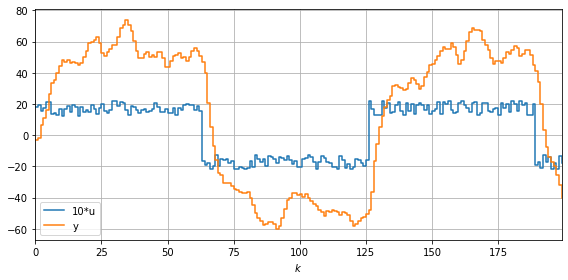

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
data = pd.read_csv(file, header=None, names=['u', 'y'])
N = len(data)

k = data.index.values
u = data.u.values
y = data.y.values

print('Number of data points:', N)
print(f'k in [{k[0]}, {k[-1]}]')

plt.figure(figsize=(8,4))
plt.plot(k, 10*u, label='10*u', drawstyle='steps-post')
plt.plot(k, y   , label='y'   , drawstyle='steps-post')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Input Fourier Transform

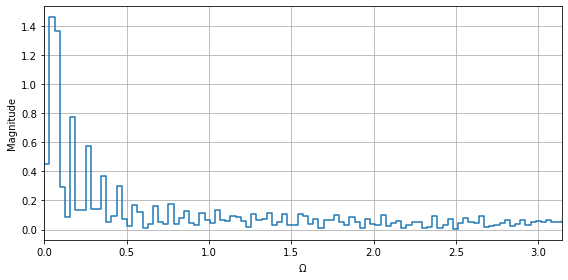

In [46]:
from scipy import fft

u_rfft = fft.rfft(u, norm='forward')
u_rfft[1:-1] = 2*u_rfft[1:-1]

u_rfft_mag = np.abs(u_rfft)
Omega = np.linspace(0, np.pi, len(u_rfft_mag))

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xlim(Omega[0], Omega[-1])
plt.xlabel(r'$\Omega$')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

## Separate Identification and Validation Data

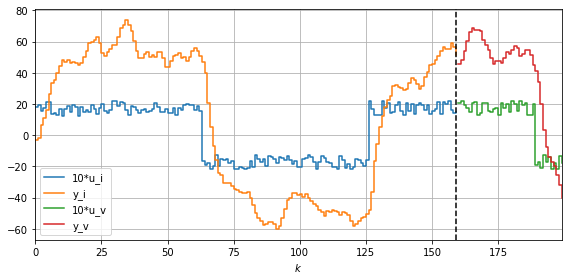

In [47]:
N_fold = 160

k_i = k[:N_fold]
u_i = u[:N_fold]
y_i = y[:N_fold]

k_v = k[N_fold:]
u_v = u[N_fold:]
y_v = y[N_fold:]

plt.figure(figsize=(8,4))
plt.plot(k_i, 10*u_i, label='10*u_i', drawstyle='steps-post')
plt.plot(k_i, y_i   , label='y_i'   , drawstyle='steps-post')
plt.plot(k_v, 10*u_v, label='10*u_v', drawstyle='steps-post')
plt.plot(k_v, y_v   , label='y_v'   , drawstyle='steps-post')
plt.axvline(k[N_fold-1], color='black', linestyle='--')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Generic Model

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k - n_k + 1] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + b_{n_b + 1} \, q^{-n_b-1}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

## Prediction Error Method

\begin{gather*}
\hat{y}[k] = L_u(q) \, u[k] + L_y(q) \, y[k]
\\
L_u(q) = \dfrac{G(q)}{H(q)}
\\
L_y(q) = 1 - \dfrac{1}{H(q)}
\end{gather*}

In [48]:
from functions import models_frame

models = models_frame()

# ARX

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + b_{n_b + 1} \, q^{-n_b-1}
\end{gather*}

In [49]:
from functions import arx

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nk_range = range(1, 3 + 1)

models_arx = arx(u_i, y_i, u_v, y_v, na_range, nb_range, nk_range)

models = pd.concat([models, models_arx], ignore_index=True)

# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + b_{n_b + 1} \, q^{-n_b-1}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

In [50]:
from functions import armax

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nc_range = range(0, 3 + 1)
nk_range = range(1, 3 + 1)

models_armax = armax(u_i, y_i, u_v, y_v, na_range, nb_range, nc_range, nk_range)

models = pd.concat([models, models_armax], ignore_index=True)

# Output Error

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + b_{n_b + 1} \, q^{-n_b-1}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [51]:
from functions import oe

nb_range = range(0, 2 + 1)
nf_range = range(1, 3 + 1) # nf = 0 causa erro no pysid!
nk_range = range(1, 3 + 1)

models_oe = oe(u_i, y_i, u_v, y_v, nb_range, nf_range, nk_range)

models = pd.concat([models, models_oe], ignore_index=True)

# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + b_{n_b + 1} \, q^{-n_b-1}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [ ]:
from functions import bj

nb_range = range(0, 2 + 1)
nc_range = range(0, 3 + 1)
nd_range = range(0, 3 + 1)
nf_range = range(0, 3 + 1)
nk_range = range(1, 3 + 1)

models_bj = bj(u_i, y_i, u_v, y_v, nb_range, nc_range, nd_range, nf_range, nk_range)

models = pd.concat([models, models_bj], ignore_index=True)

# Results

In [53]:
print('Number of models:', len(models.loc[models.B.notnull()]))
print('Number of fails: ', len(models.loc[models.B.isnull()]))

Number of models: 567
Number of fails:  216


## Sort by Prediction Cost

In [54]:
models.sort_values(by=['Jp'], inplace=True)

## Display Predictions

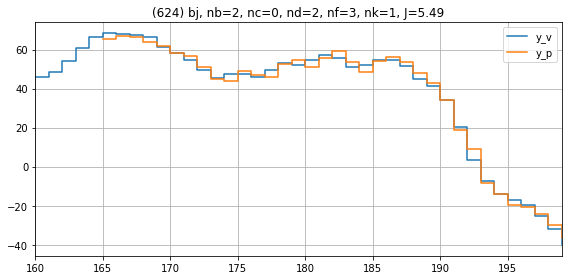

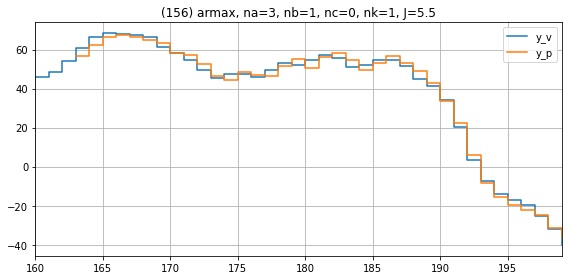

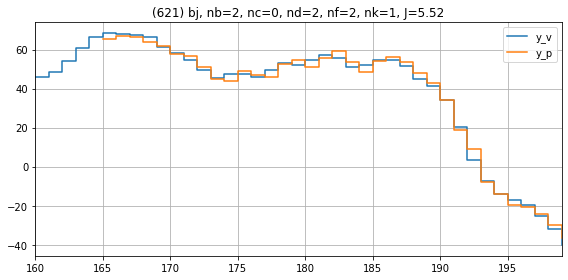

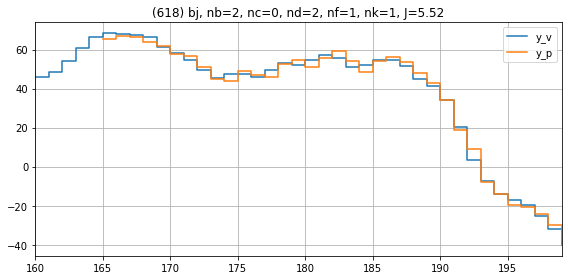

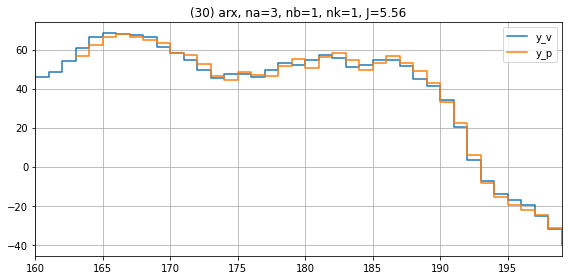

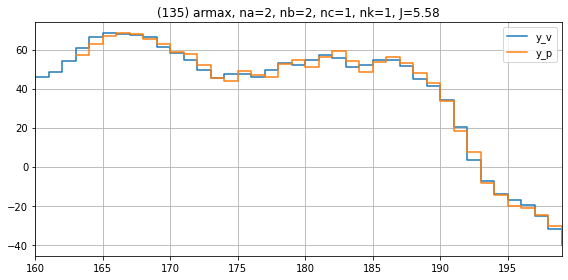

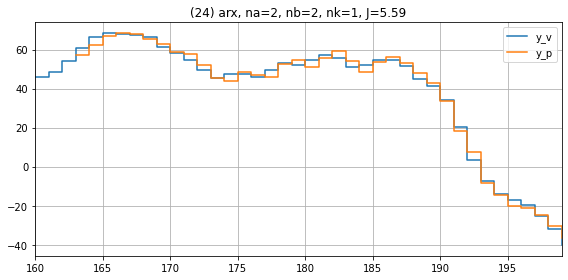

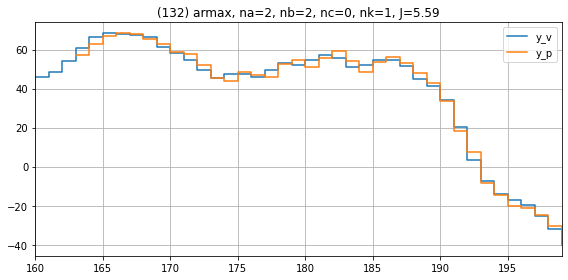

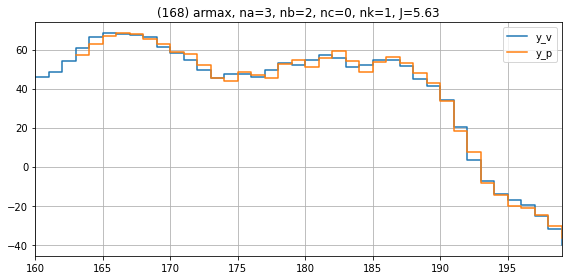

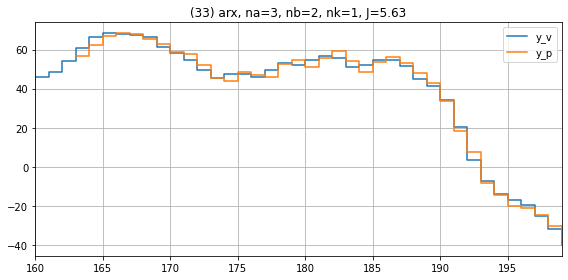

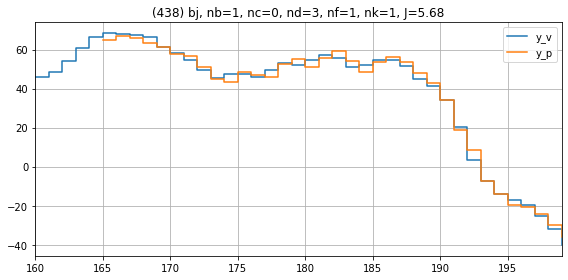

In [55]:

for i, (index, model) in enumerate(models.iterrows()):
  if i > 10:
    break

  if np.isnan(model.yp).any():
    continue

  if model.model == 'arx':
    title = f'({index}) {model.model}, na={model.na}, nb={model.nb}, nk={model.nk}, J={model.Jp:.3g}'
  elif model.model == 'armax':
    title = f'({index}) {model.model}, na={model.na}, nb={model.nb}, nc={model.nc}, nk={model.nk}, J={model.Jp:.3g}'
  elif model.model == 'oe':
    title = f'({index}) {model.model}, nb={model.nb}, nf={model.nf}, nk={model.nk}, J={model.Jp:.3g}'
  elif model.model == 'bj':
    title = f'({index}) {model.model}, nb={model.nb}, nc={model.nc}, nd={model.nd}, nf={model.nf}, nk={model.nk}, J={model.Jp:.3g}'
  else:
    assert(False)

  # display(model.G)

  plt.figure(figsize=(8,4))
  plt.title(title)
  plt.plot(k_v, y_v, label='y_v', drawstyle='steps-post')
  plt.plot(k_v[int(model.delay):], model.yp, label='y_p', drawstyle='steps-post')
  plt.xlim(k_v[0], k_v[-1])
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

## Display Best ARX

In [56]:
display(models.loc[models.model == 'arx'][['na','nb','nk','Jp','A','B',]].head(10))

,na,nb,nk,Jp,A,B
30,3,1,1,5.555782,"[1.0, -1.3524174269820388, 0.5032190693764751,...","[0.0, 2.1431634822971874, 0.8728783964686994]"
24,2,2,1,5.588947,"[1.0, -1.4068341173741103, 0.48261202067241576]","[0.0, 2.1624655631747225, 1.6108433820602714, ..."
33,3,2,1,5.633975,"[1.0, -1.3994740241334414, 0.4627146071616107,...","[0.0, 2.155788344731435, 1.6239328839062663, -..."
21,2,1,1,5.800845,"[1.0, -1.3097104301654667, 0.41739885788678394]","[0.0, 2.141831622134629, 0.9412691651247993]"
27,3,0,1,6.073861,"[1.0, -1.414703381673296, 0.556534746868992, -...","[0.0, 2.605489877940335]"
18,2,0,1,6.384207,"[1.0, -1.3707902290649023, 0.46379315525848536]","[0.0, 2.6558802749327906]"
28,3,0,2,7.490381,"[1.0, -1.3873295518220405, 0.48805419928292326...","[0.0, 0.0, 2.5495944772087906]"
19,2,0,2,7.645443,"[1.0, -1.3660455345977758, 0.46216420283874365]","[0.0, 0.0, 2.6625996144096495]"
22,2,1,2,7.890011,"[1.0, -1.4641248135410299, 0.5285400201585324]","[0.0, 0.0, 3.2667955231622616, -1.512659611800..."
31,3,1,2,8.022639,"[1.0, -1.4338646895641036, 0.4480849301598035,...","[0.0, 0.0, 3.2988193484523514, -1.597544061149..."


## Display Best ARMAX

In [57]:
display(models.loc[models.model == 'armax'][['na','nb','nc','nk','Jp','A','B','C']].head(10))

,na,nb,nc,nk,Jp,A,B,C
156,3,1,0,1,5.497648,"[1.0, -1.3532135984682516, 0.512248875146618, ...","[0.0, 2.090304259440789, 0.9702010574721682]",[1.0]
135,2,2,1,1,5.578504,"[1.0, -1.3952125968635702, 0.4728454295696849]","[0.0, 2.1015943702621334, 1.7254996639027187, ...","[1.0, 0.02155606179817526]"
132,2,2,0,1,5.59233,"[1.0, -1.409827121756505, 0.48519403768299885]","[0.0, 2.0988377241429714, 1.6896733904708754, ...",[1.0]
168,3,2,0,1,5.628132,"[1.0, -1.4039746292428246, 0.46948787592665525...","[0.0, 2.0935693054677307, 1.7011195972251176, ...",[1.0]
120,2,1,0,1,5.773071,"[1.0, -1.3156510017129306, 0.42239909692848865]","[0.0, 2.0590875259949524, 0.9928488527643409]",[1.0]
159,3,1,1,1,5.813884,"[1.0, -0.7403355455410673, -0.3702746837531395...","[0.0, 1.8561960034176979, 2.750163118516763]","[1.0, 0.5879483086612666]"
171,3,2,1,1,5.832165,"[1.0, -1.2478579261436469, 0.2488176593796698,...","[0.0, 2.0694826622572147, 2.032126694896556, -...","[1.0, 0.15927529530935752]"
147,3,0,1,1,5.852514,"[1.0, -1.5818813652995316, 0.8218133610093451,...","[0.0, 2.3681733337681052]","[1.0, -0.1876454526105165]"
144,3,0,0,1,6.020506,"[1.0, -1.425526176683317, 0.5772134533497278, ...","[0.0, 2.602281748708387]",[1.0]
99,1,2,1,1,6.020862,"[1.0, -0.8400201908842662]","[0.0, 2.239008181751805, 2.842963386808004, -0...","[1.0, 0.4336073578832773]"


## Display Best OE

In [58]:
display(models.loc[models.model == 'oe'][['nb','nf','nk','Jp','B','F',]].head(10))

,nb,nf,nk,Jp,B,F
202,2,2,2,167.747468,"[0.0, 0.0, 7.711764588803071, -6.9074618014256...","[1.0, -1.5244322818192362, 0.56005967515822]"
205,2,3,2,167.919155,"[0.0, 0.0, 7.978013556932356, -3.2286730261476...","[1.0, -0.9518156100627038, -0.3203644473814848..."
203,2,2,3,175.236329,"[0.0, 0.0, 0.0, 10.287945534826116, -9.6789022...","[1.0, -1.4015311282817564, 0.45314752381764734]"
206,2,3,3,175.267898,"[0.0, 0.0, 0.0, 10.542669800678702, -5.0891583...","[1.0, -0.870445594981947, -0.284792547770395, ..."
195,1,3,1,181.596107,"[0.0, 3.3507417420103387, -2.7664680983782803]","[1.0, -2.1777873976684754, 1.625637672754031, ..."
201,2,2,1,184.146329,"[0.0, 3.5064182856277886, -0.07824020826054166...","[1.0, -1.6007510106966596, 0.627251005434897]"
199,2,1,2,187.492546,"[0.0, 0.0, 8.08301108469978, -1.78417565469243...","[1.0, -0.8709600909127035]"
200,2,1,3,187.669636,"[0.0, 0.0, 0.0, 10.619224038586013, -4.0830704...","[1.0, -0.8720459661786835]"
193,1,2,2,193.488082,"[0.0, 0.0, 7.563069203358311, -6.423786171942781]","[1.0, -1.509661698574922, 0.5468800443643043]"
196,1,3,2,194.355839,"[0.0, 0.0, 7.838397199009468, -6.694009875361453]","[1.0, -1.4544706372946097, 0.4468435158751912,..."


## Display Best BJ

In [59]:
display(models.loc[models.model == 'bj'][['nb','nc','nd','nf','nk','Jp','B','C','D','F']].head(10))

,nb,nc,nd,nf,nk,Jp,B,C,D,F
624,2,0,2,3,1,5.487086,"[0.0, 2.0629065348803137, 2.5923868278224074, ...",[1.0],"[1.0, -1.4404393133603053, 0.551448692168246]","[1.0, -0.9703809741294812, 0.07243561599804378..."
621,2,0,2,2,1,5.521202,"[0.0, 2.078225553797191, 3.219142224909355, 0....",[1.0],"[1.0, -1.4397507909314071, 0.551256171151773]","[1.0, -0.6715518794241426, -0.13900024914449088]"
618,2,0,2,1,1,5.523886,"[0.0, 2.0827006381060156, 2.8744460838314936, ...",[1.0],"[1.0, -1.439598909860689, 0.5512577703188589]","[1.0, -0.8382382259330656]"
438,1,0,3,1,1,5.682552,"[0.0, 2.0390090637737885, 2.8254641290052014]",[1.0],"[1.0, -1.4025066670548512, 0.452114333217633, ...","[1.0, -0.8345752742545625]"
636,2,0,3,3,1,5.693496,"[0.0, 2.0368257083297285, 2.559337916382717, -...",[1.0],"[1.0, -1.4027978487313173, 0.44949906560393765...","[1.0, -0.9765890280657465, 0.06583147020049954..."
630,2,0,3,1,1,5.720996,"[0.0, 2.0651188040194453, 2.8472105856991035, ...",[1.0],"[1.0, -1.4031374648533834, 0.45311544230700734...","[1.0, -0.8400225226363037]"
633,2,0,3,2,1,5.72537,"[0.0, 2.05949458380128, 3.2660340001571333, 0....",[1.0],"[1.0, -1.4028571114241373, 0.4519158524403777,...","[1.0, -0.6366859135071263, -0.1700750651331207]"
444,1,0,3,3,1,5.849457,"[0.0, 2.0456262651932344, 3.0229803342026367]",[1.0],"[1.0, -1.4025044139196285, 0.4502121350537656,...","[1.0, -0.7513539062143707, -0.1004719860095837..."
441,1,0,3,2,1,5.894921,"[0.0, 2.064491311624907, 3.0020192926426854]",[1.0],"[1.0, -1.4030810205462132, 0.45270793243358015...","[1.0, -0.7657343388441841, -0.06240536478589564]"
426,1,0,2,1,1,5.941071,"[0.0, 2.0521980727132623, 2.863328192040819]",[1.0],"[1.0, -1.4390781725836415, 0.5501824208117837]","[1.0, -0.8324639569929325]"


## Display Model in Class

G =


TransferFunction(array([ 2.16246556,  1.61084338, -1.6016382 ]), array([ 1.        , -1.40683412,  0.48261202,  0.        ]), True)

H =


TransferFunction(array([1., 0., 0.]), array([ 1.        , -1.40683412,  0.48261202]), True)

J_p = 5.588946926532913


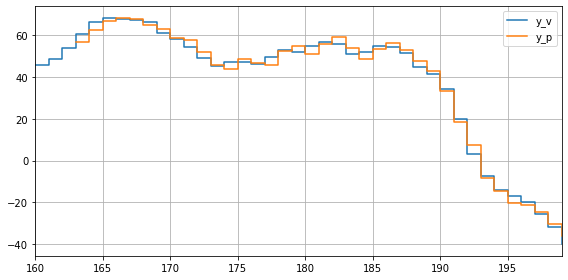

In [60]:
model = models.loc[(models.model == 'arx') & (models.na == 2) & (models.nb == 2) & (models.nk == 1)]
assert(len(model) == 1)
model = model.iloc[0]

print('G =')
display(model.G)
print('H =')
display(model.H)
print('J_p =', model.Jp)

plt.figure(figsize=(8,4))
plt.plot(k_v, y_v, label='y_v', drawstyle='steps-post')
plt.plot(k_v[int(model.delay):], model.yp, label='y_p', drawstyle='steps-post')
plt.xlim(k_v[0], k_v[-1])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()